For analysis of the results, jumpto [here](https://colab.research.google.com/drive/1GqDjUDZ40JvFX1wrv6d99lILkp2R7RRw?authuser=1#scrollTo=xUBiqUfnCgd_&line=2&uniqifier=1)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as tfls

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
(ds_train, ds_val,ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:90%]','train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompletePZQFYI/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompletePZQFYI/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
def normaliseImgData(data):
  # From 0 - 255 range to 0 - 1
  return tf.cast(data, tf.float32)/ 255.

x_train_n= normaliseImgData(x_train)
x_test_n= normaliseImgData(x_test)

In [8]:
assert x_train_n.shape == (50000, 32, 32, 3)
assert x_test_n.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [9]:
#CONSTANTS
img_SHAPE = (32,32,3,)

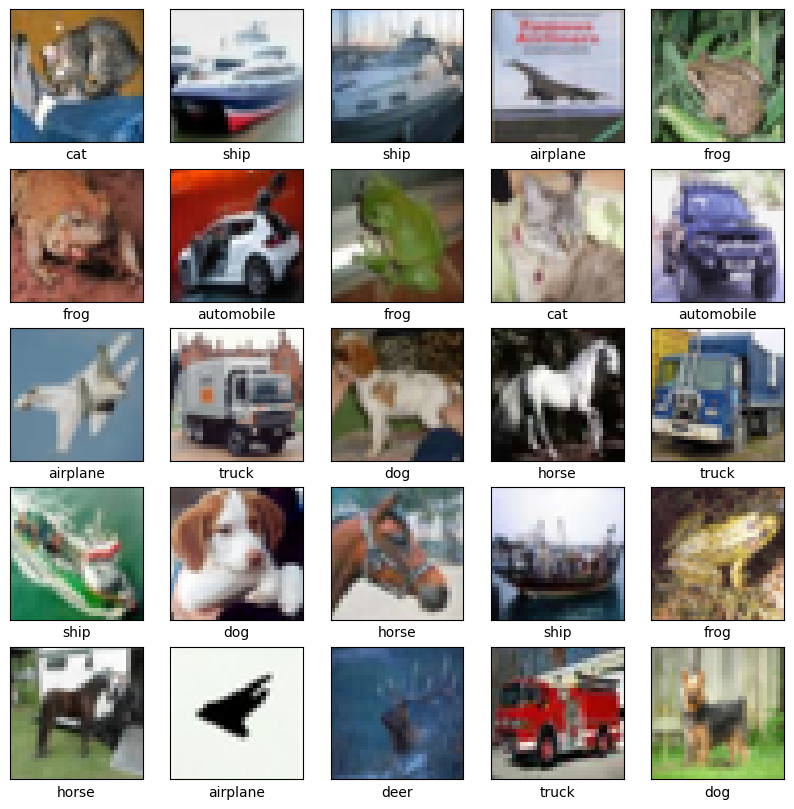

In [61]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_names = np.array(class_names)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_n[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_test[i][0]])
plt.show()

In [11]:
def plotProgress(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [12]:
checkpoint_filepath = 'model_checkpoint.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True to save only the model's weights, not the whole model
    monitor='val_accuracy',  # Choose a metric to monitor (e.g., val_loss or val_accuracy)
    save_best_only=True,  # Set to True to save only the best model based on the monitored metric
    mode='max'  # Choose 'max' for accuracy, 'min' for loss, etc., depending on the monitored metric
)


In [18]:
data_augmentation = tf.keras.Sequential([
  tfls.RandomFlip("horizontal"),
  tfls.RandomRotation(0.005),
])

In [19]:
i = tfls.Input(shape=x_train[0].shape)
x = data_augmentation(i)
x = tfls.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.MaxPooling2D((2, 2))(x)

x = tfls.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.MaxPooling2D((2, 2))(x)

x = tfls.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tfls.BatchNormalization()(x)
x = tfls.MaxPooling2D((2, 2))(x)

x = tfls.Flatten()(x)
x = tfls.Dropout(0.2)(x)

# Hidden layer
x = tfls.Dense(1024, activation='relu')(x)
x = tfls.Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = tfls.Dense(10)(x)

model = tf.keras.Model(i, x)

# model description
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                          

In [20]:
learningRate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learningRate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [21]:
history = model.fit(ds_train, epochs=10, validation_data=ds_val, callbacks=[checkpoint_callback])

Epoch 1/10
352/352 [==============================] - 29s 22ms/step - loss: 1.7360 - accuracy: 0.4104 - val_loss: 2.7239 - val_accuracy: 0.2258
Epoch 2/10
352/352 [==============================] - 6s 17ms/step - loss: 1.2721 - accuracy: 0.5474 - val_loss: 1.1331 - val_accuracy: 0.5936
Epoch 3/10
352/352 [==============================] - 6s 16ms/step - loss: 1.1104 - accuracy: 0.6068 - val_loss: 1.1318 - val_accuracy: 0.6070
Epoch 4/10
352/352 [==============================] - 6s 17ms/step - loss: 0.9976 - accuracy: 0.6466 - val_loss: 0.9758 - val_accuracy: 0.6538
Epoch 5/10
352/352 [==============================] - 6s 18ms/step - loss: 0.9132 - accuracy: 0.6777 - val_loss: 0.8821 - val_accuracy: 0.6848
Epoch 6/10
352/352 [==============================] - 6s 16ms/step - loss: 0.8437 - accuracy: 0.7018 - val_loss: 0.8672 - val_accuracy: 0.6942
Epoch 7/10
352/352 [==============================] - 6s 17ms/step - loss: 0.7836 - accuracy: 0.7236 - val_loss: 0.8032 - val_accuracy: 0.716

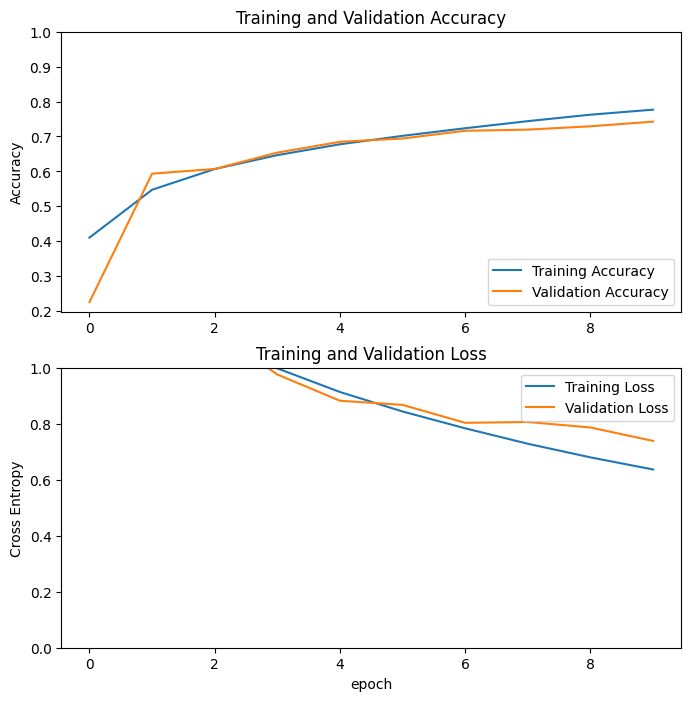

In [22]:
plotProgress(history)

In [23]:
history_continued = model.fit(ds_train, initial_epoch=history.epoch[-1], epochs=30, validation_data=ds_val, callbacks=[checkpoint_callback])


Epoch 10/30
352/352 [==============================] - 6s 16ms/step - loss: 0.5984 - accuracy: 0.7900 - val_loss: 0.7165 - val_accuracy: 0.7426
Epoch 11/30
352/352 [==============================] - 7s 19ms/step - loss: 0.5623 - accuracy: 0.8018 - val_loss: 0.7135 - val_accuracy: 0.7504
Epoch 12/30
352/352 [==============================] - 6s 17ms/step - loss: 0.5313 - accuracy: 0.8139 - val_loss: 0.6836 - val_accuracy: 0.7598
Epoch 13/30
352/352 [==============================] - 6s 16ms/step - loss: 0.4971 - accuracy: 0.8246 - val_loss: 0.6990 - val_accuracy: 0.7500
Epoch 14/30
352/352 [==============================] - 6s 17ms/step - loss: 0.4665 - accuracy: 0.8345 - val_loss: 0.6623 - val_accuracy: 0.7714
Epoch 15/30
352/352 [==============================] - 6s 16ms/step - loss: 0.4400 - accuracy: 0.8458 - val_loss: 0.6682 - val_accuracy: 0.7654
Epoch 16/30
352/352 [==============================] - 6s 17ms/step - loss: 0.4105 - accuracy: 0.8562 - val_loss: 0.6645 - val_accuracy:

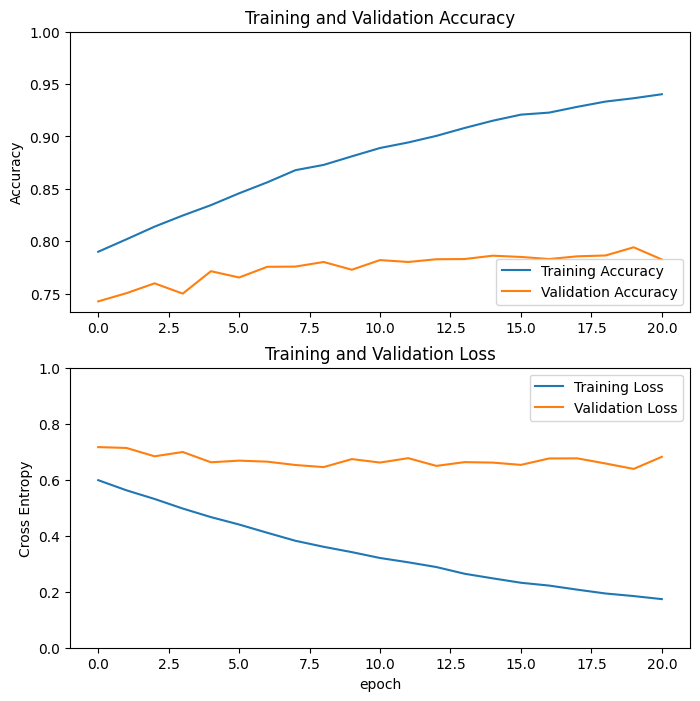

In [24]:
plotProgress(history_continued)

In [25]:
history_continued_2 = model.fit(ds_train, initial_epoch=history_continued.epoch[-1], epochs=60, validation_data=ds_val, callbacks=[checkpoint_callback])


Epoch 30/60
352/352 [==============================] - 6s 16ms/step - loss: 0.1605 - accuracy: 0.9452 - val_loss: 0.6860 - val_accuracy: 0.7904
Epoch 31/60
352/352 [==============================] - 6s 17ms/step - loss: 0.1544 - accuracy: 0.9469 - val_loss: 0.6808 - val_accuracy: 0.7958
Epoch 32/60
352/352 [==============================] - 6s 16ms/step - loss: 0.1427 - accuracy: 0.9511 - val_loss: 0.6871 - val_accuracy: 0.7908
Epoch 33/60
352/352 [==============================] - 6s 17ms/step - loss: 0.1356 - accuracy: 0.9538 - val_loss: 0.7189 - val_accuracy: 0.7808
Epoch 34/60
352/352 [==============================] - 6s 16ms/step - loss: 0.1311 - accuracy: 0.9552 - val_loss: 0.6897 - val_accuracy: 0.7960
Epoch 35/60
352/352 [==============================] - 6s 17ms/step - loss: 0.1257 - accuracy: 0.9574 - val_loss: 0.7108 - val_accuracy: 0.7954
Epoch 36/60
352/352 [==============================] - 6s 16ms/step - loss: 0.1192 - accuracy: 0.9579 - val_loss: 0.7119 - val_accuracy:

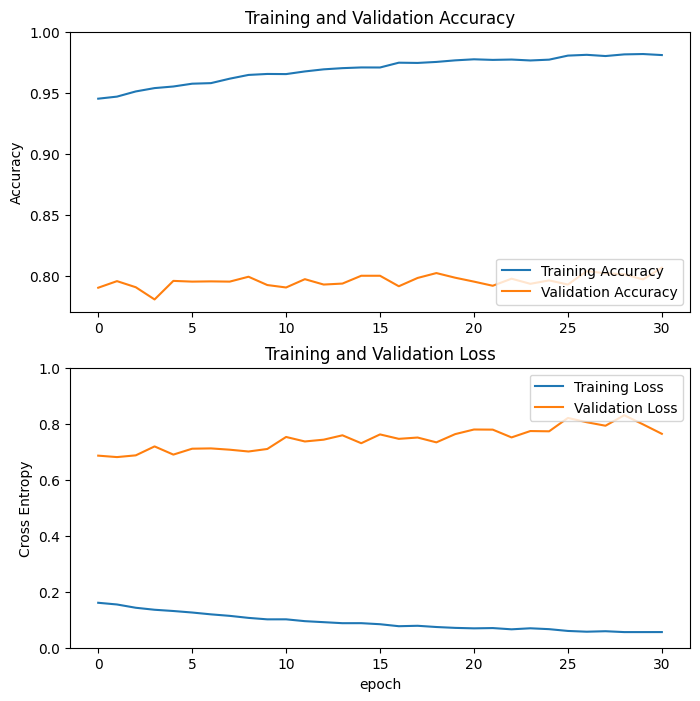

In [26]:
plotProgress(history_continued_2)

In [27]:
def getProbability(p_arr):
  p = np.exp(p_arr)
  p_sum = np.sum(p,axis=1,keepdims=True)
  return p/p_sum

def getCIFAR10Label(i):
  return class_names[i]


def getCIFAR10ClassIndex(p_arr):
  if p_arr.ndim == 2:
    return np.argmax(p_arr,axis=1,keepdims=True)
  return np.argmax(p_arr)

In [29]:
# The model weights (that are considered the best) are loaded into the
# model.
model.load_weights(checkpoint_filepath)

In [31]:
test_scores = model.evaluate(x_test_n, y_test, verbose=2)
print("Best Test loss:", test_scores[0])
print("Best Test accuracy:", test_scores[1])

313/313 - 1s - loss: 0.8090 - accuracy: 0.7992 - 1s/epoch - 4ms/step
Best Test loss: 0.8089537024497986
Best Test accuracy: 0.7991999983787537


In [32]:
# model.save("CIFAR10_Model.keras")

In [ ]:
# model = tf.keras.models.load_model("MNIST_Model.keras")

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [34]:
# Getting Started
perturbations = create_adversarial_pattern(x_test_n,y_test)
perturbations.shape

TensorShape([10000, 32, 32, 3])

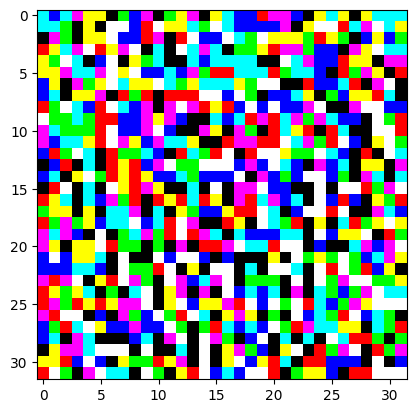

In [35]:
# Displaying perturbation
tempP = perturbations[0]
plt.figure()
plt.imshow(tempP)

In [37]:
x_test = x_test_n

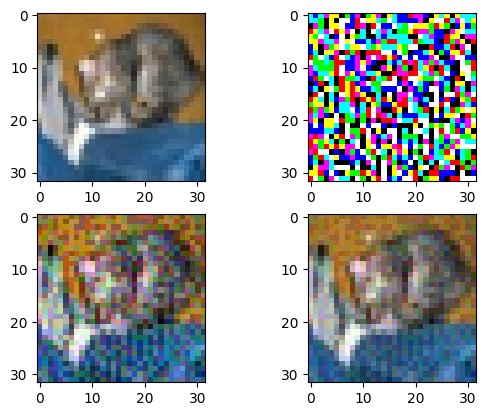

In [42]:
fig, axs = plt.subplots(2, 2)
axs[0][0].imshow(x_test[0])
axs[0][1].imshow(tempP*0.5+0.5)
tempImg1 = tf.clip_by_value((x_test[0]+0.1*tempP),0,1)
axs[1][0].imshow(tempImg1)
tempImg2 = tf.clip_by_value((x_test[0]+0.05*tempP),0,1)
axs[1][1].imshow(tempImg2)

In [43]:
# np.save("perturbations_CIFAR10.npy",perturbations)

In [ ]:
# perturbations = np.save("perturbations_MNIST.npy")

In [44]:
accuracies = []
epsilon = [0,10**(-5),10**(-4),10**(-3),10**(-2),3*10**(-2),5*10**(-2),7*10**(-2),10**(-1),2*10**(-1),3*10**(-1),5*10**(-1),7*10**(-1)]

for e in epsilon:
  test_data = tf.clip_by_value(x_test+(e*perturbations),clip_value_min=0,clip_value_max=1)
  test_scores = model.evaluate(test_data, y_test, verbose=2)
  accuracies.append(test_scores[1])

313/313 - 1s - loss: 0.8090 - accuracy: 0.7992 - 940ms/epoch - 3ms/step
313/313 - 1s - loss: 0.8114 - accuracy: 0.7985 - 917ms/epoch - 3ms/step
313/313 - 1s - loss: 0.8344 - accuracy: 0.7942 - 1s/epoch - 4ms/step
313/313 - 1s - loss: 1.1102 - accuracy: 0.7457 - 1s/epoch - 4ms/step
313/313 - 1s - loss: 5.0366 - accuracy: 0.4485 - 907ms/epoch - 3ms/step
313/313 - 1s - loss: 8.3994 - accuracy: 0.3276 - 908ms/epoch - 3ms/step
313/313 - 1s - loss: 9.0380 - accuracy: 0.2496 - 899ms/epoch - 3ms/step
313/313 - 1s - loss: 9.1264 - accuracy: 0.2059 - 894ms/epoch - 3ms/step
313/313 - 1s - loss: 8.9500 - accuracy: 0.1653 - 933ms/epoch - 3ms/step
313/313 - 1s - loss: 8.9131 - accuracy: 0.1196 - 927ms/epoch - 3ms/step
313/313 - 1s - loss: 10.9325 - accuracy: 0.1048 - 946ms/epoch - 3ms/step
313/313 - 1s - loss: 16.3022 - accuracy: 0.1024 - 975ms/epoch - 3ms/step
313/313 - 1s - loss: 19.2428 - accuracy: 0.0980 - 1s/epoch - 4ms/step


Text(0.5, 1.0, 'Accuracy Drop')

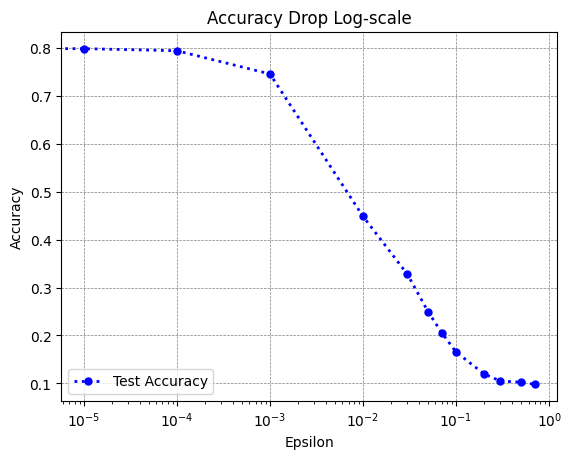

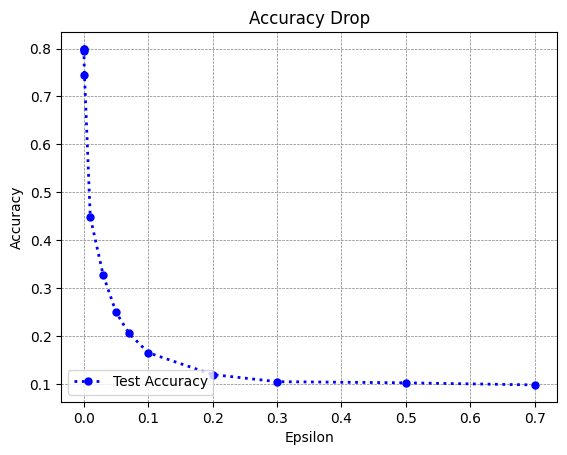

In [45]:
plt.figure()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.plot(epsilon,accuracies,color='blue', marker='o', linestyle=':',linewidth=2, markersize=5, label='Test Accuracy')
plt.legend(loc='lower left')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.title('Accuracy Drop Log-scale')

plt.figure()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.plot(epsilon,accuracies,color='blue', marker='o', linestyle=':',linewidth=2, markersize=5, label='Test Accuracy')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.title('Accuracy Drop')

------
Further analysis with `epsilon = 10**(-3) ~ 0.001`




In [46]:
e = 0.001
test_data = tf.clip_by_value(x_test+(e*perturbations),clip_value_min=0,clip_value_max=1)
test_scores = model.evaluate(test_data,y_test,verbose = 2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 1s - loss: 1.1102 - accuracy: 0.7457 - 955ms/epoch - 3ms/step
Test loss: 1.110160231590271
Test accuracy: 0.7457000017166138


In [47]:
predictions = model.predict(test_data)
true_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [50]:
pred_class = getCIFAR10ClassIndex(predictions)
t_pred_class = getCIFAR10ClassIndex(true_pred)
assert pred_class.shape == (10000,1)
assert t_pred_class.shape == (10000,1)

In [51]:
pred_match = (pred_class == t_pred_class)
print( f"Match shape: {pred_match.shape}")
np.sum(pred_match)

Match shape: (10000, 1)


9426

Some images which are differently than the their clean versions

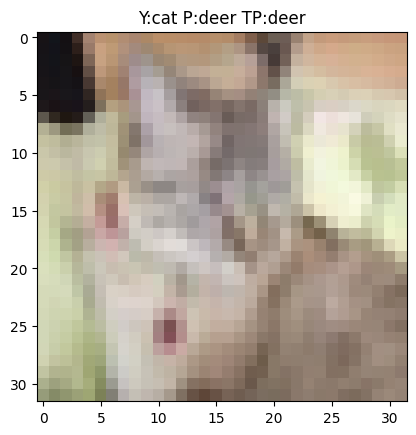

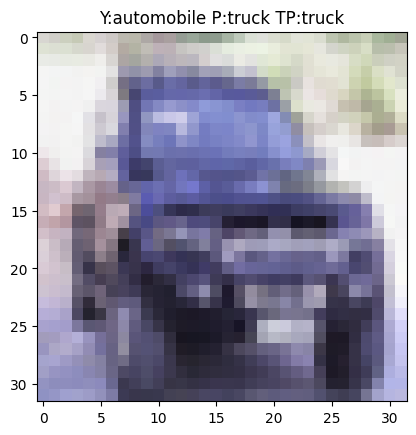

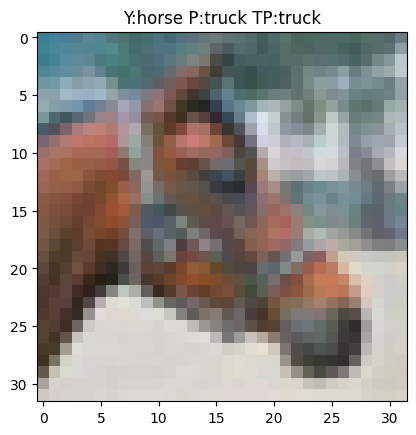

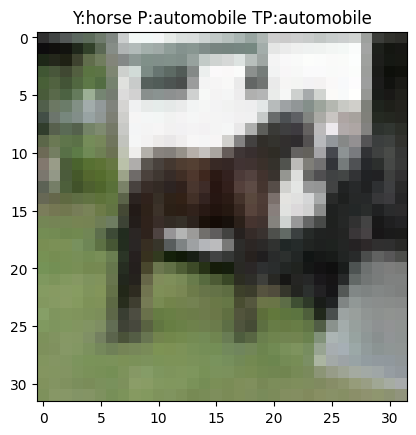

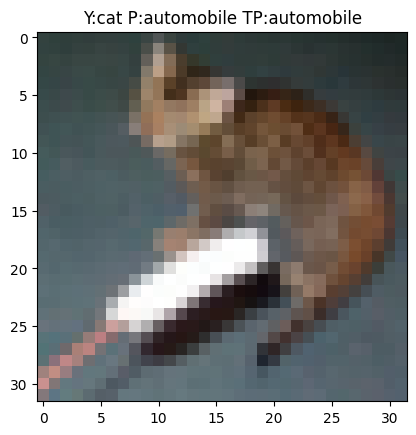

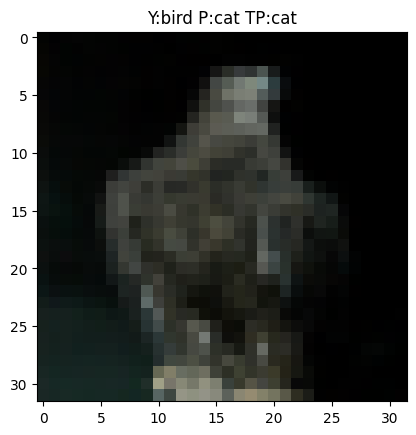

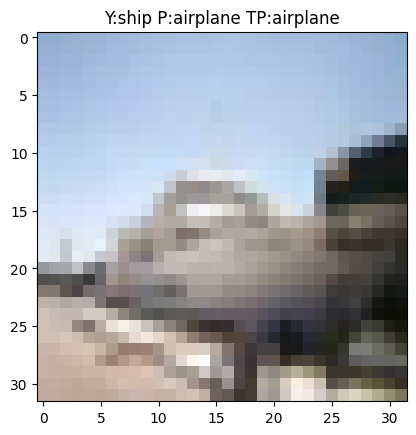

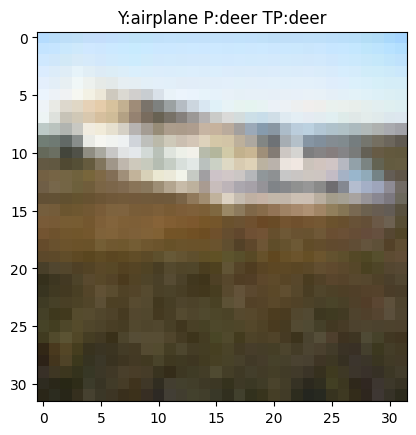

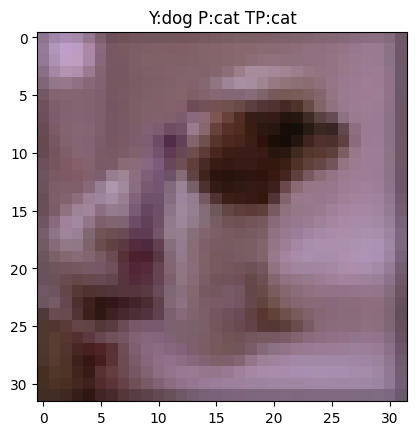

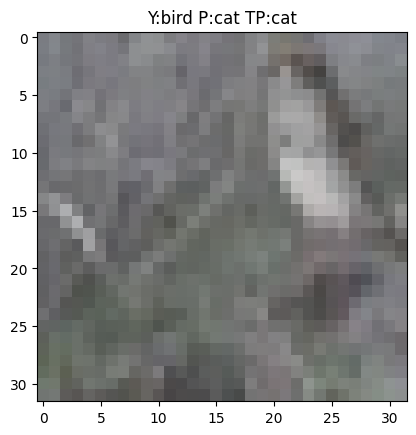

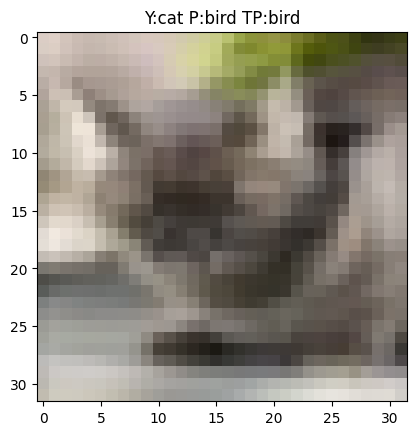

In [53]:
misCount = 0
for index, correct in enumerate(pred_match):
  if not correct.all():
    plt.figure()
    misCount +=1
    plt.imshow(test_data[index])
    plt.title(f"Y:{getCIFAR10Label(y_test[index][0])} P:{getCIFAR10Label(pred_class[index][0])} TP:{getCIFAR10Label(pred_class[index][0])}")
    plt.show()
  if misCount>10:
    break


Further numerical analysis!


In [56]:
pred_class = pred_class.reshape(-1)
t_pred_class = t_pred_class.reshape(-1)
y_test = y_test.reshape(-1)

In [62]:
cc = mms = mmd = cm = mc = 0
ccl = []
mmsl = []
mmdl = []
cml = []
mcl = []
# cc : correctly classified before and after
# mm : misclassified before and after
# cm : correctly classified now misclassified
# mc : misclassified now correctly classified

y = getCIFAR10Label(y_test)
tp = getCIFAR10Label(t_pred_class)
p = getCIFAR10Label(pred_class)
for index in range(10000):
  if tp[index] == y[index]:
    # True predictions are right
    if p[index] == y[index]:
      cc+=1
      ccl.append(index)
    else:
      cm +=1
      cml.append(index)
  else:
    # True predictions are wrong
    if p[index] != y[index]:
      if p[index] == tp[index]:
        mms+=1
        mmsl.append(index)
      else:
        mmd+=1
        mmdl.append(index)
    else:
      mc +=1
      mcl.append(index)

In [63]:
print(f"cc:{cc} \nmms:{mms}\nmmd:{mmd} \ncm:{cm} \nmc:{mc}")

cc:7456 
mms:1970
mmd:37 
cm:536 
mc:1


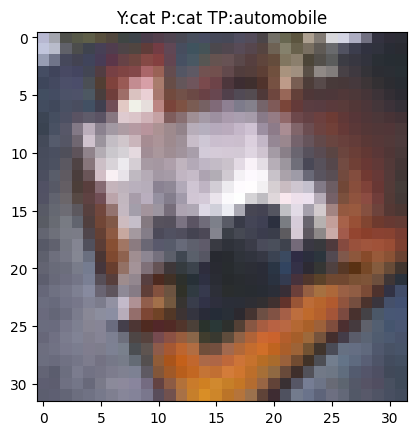

In [64]:
for index in mcl:
  plt.figure()
  plt.imshow(test_data[index])
  plt.title(f"Y:{y[index]} P:{p[index]} TP:{tp[index]}")
  plt.show()

Now analysis of misclassified examples who's clean version was correctly classified.

In [65]:
y_cm = y[cml]
p_cm = p[cml]


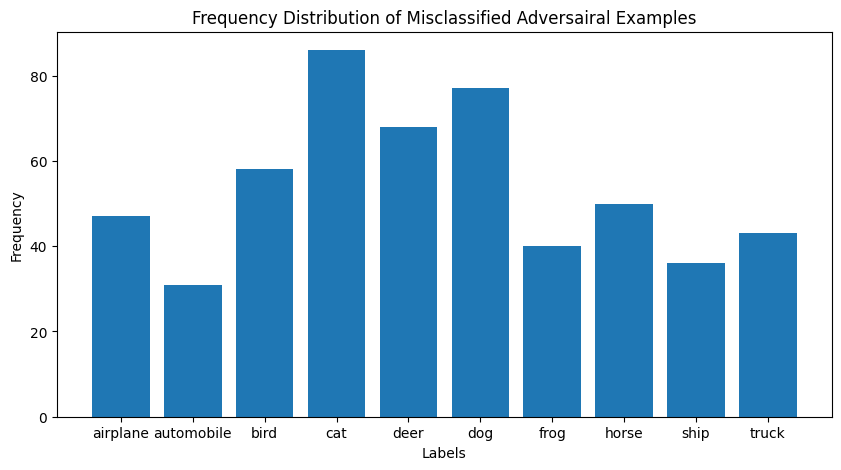

In [67]:
unique_values, counts = np.unique(y_cm, return_counts=True)
plt.figure(figsize=(10,5))
plt.bar(unique_values, counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Misclassified Adversairal Examples')
plt.show()